# Validation of Trained All IBD Fatigue ML Model on Spanish Data

Validation performed and carried out by Dr Beatriz Gros Alcalde and Dr. Eva Iglesias-Flores

On first inspection of df, it is noted that overall rates of fatigue in this cohort are not very high compared to the Scottish data. Potentially, asking patients might be lead to underreporting of fatigue compared to perhaps a written questionnaire.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
import numpy as np
import pickle
import shap
import pickle
import statsmodels.api as sm

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from src.data.preprocessing import map_season
from src.data.conversions import convert_creatinine_from_mg_dl_to_umol_l, convert_urea_from_mg_dl_to_mmol_l, capitalize_first_letter
from src.config import NUMERICAL_FEATURES

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel(
    "data/fatigue_ml_data_validation_spain.xlsx", sheet_name="fatigue_validation"
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
target_df = pd.read_csv("output/dnn/export/X_test.csv")

## Data Cleaning

Urea and Creatinine units are different in Spain. Note: Bea converted her creatinine values by multiplying 100.

Creatinine statistics before correction:
Min: 0.57, Max: 119.0
Mean: 42.82217821782178, Median: 57.0
Number of values > 50: 51


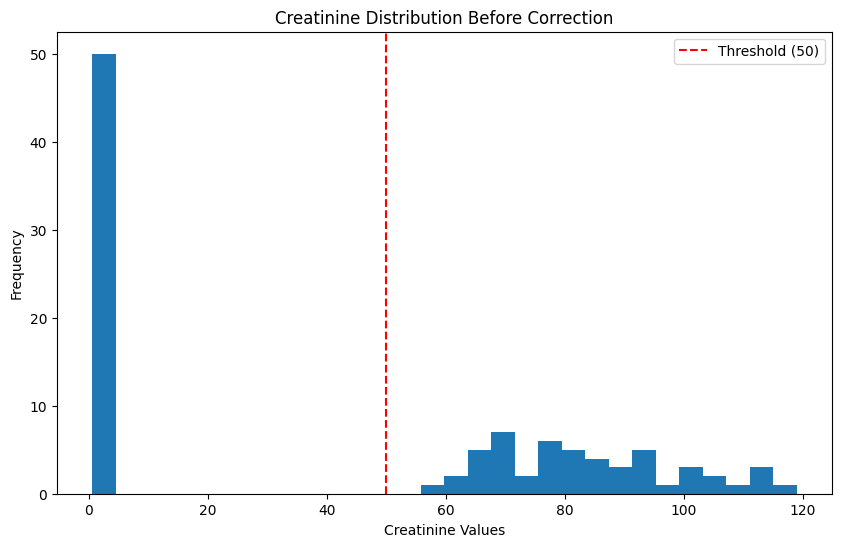


Creatinine statistics after correction:
Min: 0.57, Max: 2.2
Mean: 0.8795049504950496, Median: 0.85


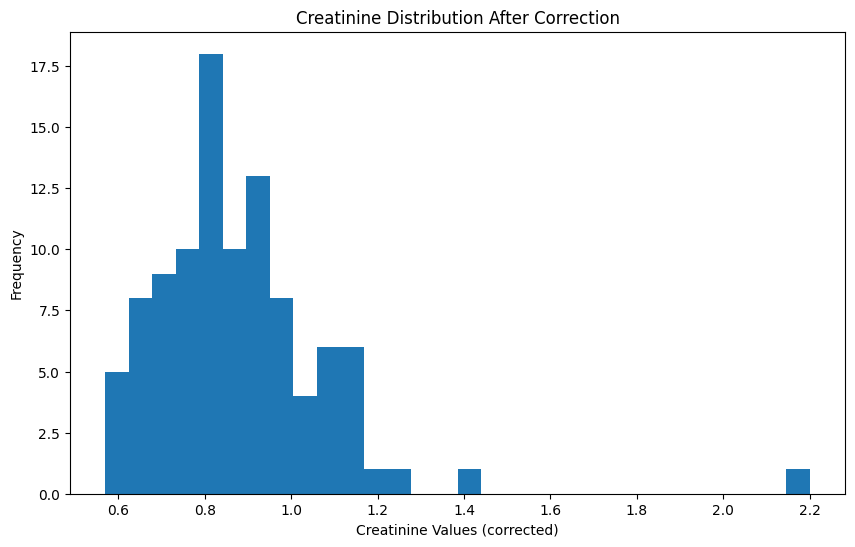

In [4]:
# Find outliers in creatinine values
print("Creatinine statistics before correction:")
print(f"Min: {df['creatinine'].min()}, Max: {df['creatinine'].max()}")
print(f"Mean: {df['creatinine'].mean()}, Median: {df['creatinine'].median()}")
print(f"Number of values > 50: {(df['creatinine'] > 50).sum()}")

# Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(df['creatinine'], bins=30)
plt.title('Creatinine Distribution Before Correction')
plt.xlabel('Creatinine Values')
plt.ylabel('Frequency')
plt.axvline(50, color='red', linestyle='--', label='Threshold (50)')
plt.legend()
plt.show()

# Correct the large creatinine values by dividing by 100
df['creatinine_corrected'] = df['creatinine'].apply(lambda x: x/100 if x > 50 else x)

# Show the corrected statistics
print("\nCreatinine statistics after correction:")
print(f"Min: {df['creatinine_corrected'].min()}, Max: {df['creatinine_corrected'].max()}")
print(f"Mean: {df['creatinine_corrected'].mean()}, Median: {df['creatinine_corrected'].median()}")

# Create a histogram for the corrected values
plt.figure(figsize=(10, 6))
plt.hist(df['creatinine_corrected'], bins=30)
plt.title('Creatinine Distribution After Correction')
plt.xlabel('Creatinine Values (corrected)')
plt.ylabel('Frequency')
plt.show()

# Replace the original creatinine column with the corrected values
df['creatinine'] = df['creatinine_corrected']
df.drop('creatinine_corrected', axis=1, inplace=True)

In [ ]:


df['urea'] = convert_urea_from_mg_dl_to_mmol_l(df['urea'])
df['creatinine'] = convert_creatinine_from_mg_dl_to_umol_l(df['creatinine'])

## Transform Excel Data to Match Input DataFrame

In [6]:
df["fatigue_outcome"] = df[
    "On how many days over the last 14 days have you felt fatigued? (0-14)"
].apply(lambda x: 1 if x >= 10 else 0)

In [7]:
# Transform Excel File into the same shape as the data used for the ml model

df["sex"] = df["sex"].map({"Male": 1, "Female": 0})


In [8]:
cols_to_rename = {
    "height_cm": "height",
    "weight_kg": "weight",
    "has_symptoms_of_active_ibd": "has_active_symptoms",
    "sampling_aminosalicylates (any)": "sampling_asa",
    "sampling_antibiotics": "sampling_abx",
    "study_group": "study_group_name",
    "smoking_status": "is_smoker",
}

df.rename(columns=cols_to_rename, inplace=True)

In [9]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [10]:
# calculate age at diagnosis based on age this year 2025, minus the year of date_of_diagnosis
df["age_at_diagnosis"] = df["age"] - (2025 - df["date_of_diagnosis"].dt.year)

# Feature Engineering Matching Up to Data Preprocessing Notebook

In [11]:
# Match up with 2_ml_data_preprocessing.py

df["disease_duration_weeks"] = (
    df["date_recorded"] - df["date_of_diagnosis"]
).dt.days / 7
df["season"] = df["date_recorded"].apply(map_season)
df["diagnosis_year"] = df["date_of_diagnosis"].dt.year

In [12]:
df["study_group_name"] = df["study_group_name"].apply(lambda x: x.upper())

In [13]:
# Change Yes and No to 1 and 0 for the following columns
cols_to_map = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

for col in cols_to_map:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [14]:
df["montreal_cd_location"].value_counts()

montreal_cd_location
L1 Ileal          30
L3 Ileocolonic    25
L2 Colonic        11
Name: count, dtype: int64

In [ ]:
# Capitalize the first letter in smoking_status
df["is_smoker"] = df["is_smoker"].apply(capitalize_first_letter)

### One-Hot Encoding of Categorical Variables

In [16]:
categorical_features_for_one_hot_encoding = [
    "study_group_name",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_extent",
    "montreal_uc_severity",
    "is_smoker",
    "season",
]

df = pd.get_dummies(df, columns=categorical_features_for_one_hot_encoding, dtype=int)

### Fill in empty seasons

In [17]:
# check if season_autumn, season_summer, season_winter, season_spring are in the columns, if not in columns create it and fill with 0

for season in ["autumn", "summer", "winter", "spring"]:
    if f"season_{season}" not in df.columns:
        df[f"season_{season}"] = 0
        df[f"season_{season}"] = df[f"season_{season}"].astype(int)

In [18]:
cols_to_drop = [
    "Who collected this data",
    "Clinical Setting (inpatient, outpatient, endoscopy, infusion unit, etc.)",
    "Unnamed: 49",
    "On how many days over the last 14 days have you felt fatigued? (0-14)",
    "date_of_diagnosis",
    "date_recorded",
]

# Drop columns that are not needed
df.drop(columns=cols_to_drop, inplace=True)

In [19]:
# Compare columns in df and target_df
# Check for columns in df that are not in target_df
df_columns_not_in_target_df = set(df.columns) - set(target_df.columns)

print("Columns in df that are not in target_df:" + str(df_columns_not_in_target_df))
target_df_columns_not_in_df = set(target_df.columns) - set(df.columns)
print("Columns in target_df that are not in df:" + str(target_df_columns_not_in_df))


Columns in df that are not in target_df:{'fatigue_outcome'}
Columns in target_df that are not in df:set()


## Check for Missing Data

In [20]:
nans_to_fill_with_zero = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

# Fill NaN values with 0
for col in nans_to_fill_with_zero:
    df[col] = df[col].fillna(0)

In [21]:
# plot a heatmap to show missing data in df
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(20, 10))
# sns.heatmap(df.isnull(), cbar=False, cmap="Reds", yticklabels=False)
# plt.title("Heatmap of Missing Data")
# plt.show()

## Create X_spain and y_spain DataFrames

Perform checking to ensure they match input dataframe

In [22]:
# Create Y_spain
y_spain = df["fatigue_outcome"].copy()
X_spain = df.drop(columns=["fatigue_outcome"]).copy()
X_spain = X_spain[target_df.columns]

# Verify columns match
assert set(X_spain.columns) == set(target_df.columns), "Columns do not match!"

In [23]:
# Ensure datatypes match
for col in X_spain.columns:
    X_spain[col] = X_spain[col].astype(target_df[col].dtype)

# Verify all data types match
print("\nChecking data types match:")
mismatched_types = [(col, X_spain[col].dtype, target_df[col].dtype) 
                    for col in X_spain.columns 
                    if X_spain[col].dtype != target_df[col].dtype]
if mismatched_types:
    print("Mismatched types:", mismatched_types)
else:
    print("All data types match!")


Checking data types match:
All data types match!


## Scale Data

In [24]:
# Load the scaler that was used on the training data
scaler = joblib.load('output/dnn/export/scaler_2025-04-09.pkl')

numerical_features = [
    col
    for col in NUMERICAL_FEATURES
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]

# Apply the same scaling
X_spain[numerical_features] = scaler.transform(X_spain[numerical_features])

## Load the Keras Model

In [25]:
model = keras.saving.load_model("output/dnn/export/fatigue_model_2025-04-09.keras")

In [26]:
# Get probability predictions
y_pred_proba = model.predict(X_spain)
# Get binary predictions using 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_spain, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_spain, y_pred))

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_spain, y_pred_proba)
roc_auc = auc(fpr, tpr)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        80
           1       0.40      0.48      0.43        21

    accuracy                           0.74       101
   macro avg       0.63      0.64      0.63       101
weighted avg       0.76      0.74      0.75       101


Confusion Matrix:
[[65 15]
 [11 10]]


In [27]:
try:
    with open('output/statsmodels/statsmodels_logreg.pkl', 'rb') as f:
        logreg_model = pickle.load(f)

    # Prepare data for statsmodels prediction (add constant if needed)
    # Check if the model expects a constant term (intercept)
    # This depends on how the model was originally trained in 9_traditional_logreg_using_statsmodel.ipynb
    # Assuming X_spain columns match the training features and order.
    # If the original model used sm.add_constant, add it here.
    # For now, let's assume it might need a constant based on typical statsmodels usage.
    X_spain_const = sm.add_constant(X_spain, has_constant='add')

    # Ensure columns match the model's exog_names, adding missing ones with 0 if necessary
    missing_cols = set(logreg_model.params.index) - set(X_spain_const.columns)
    for c in missing_cols:
        X_spain_const[c] = 0
    # Ensure the order of columns matches the model's parameters
    X_spain_const = X_spain_const[logreg_model.params.index]


    # Get probability predictions for Logistic Regression model
    y_pred_proba_logreg = logreg_model.predict(X_spain_const)

    # Calculate ROC curve and AUC for Logistic Regression model
    fpr_logreg, tpr_logreg, _ = roc_curve(y_spain, y_pred_proba_logreg)
    roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
    logreg_loaded = True
except FileNotFoundError:
    print("\\nWarning: Logistic regression model file not found at output/statsmodels/stasmodels_logreg.pkl")
    logreg_loaded = False
except Exception as e:
    print(f"\\nError loading or predicting with logistic regression model: {e}")
    logreg_loaded = False

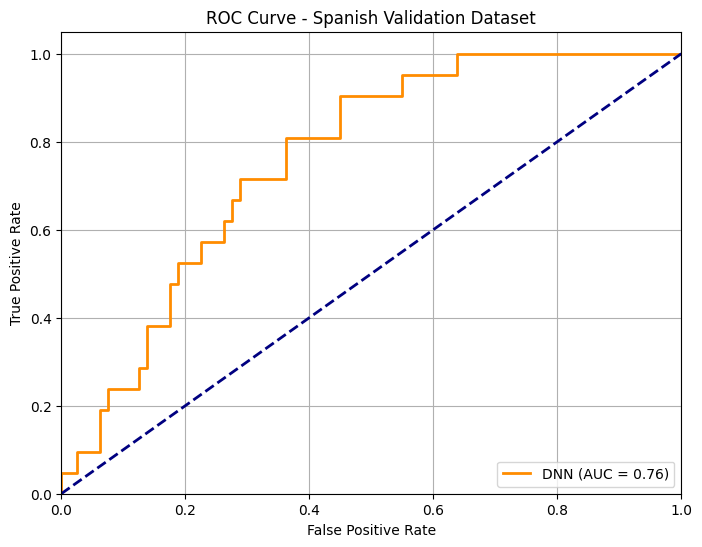

\nAUC Score (Keras DNN): 0.761
AUC Score (Logistic Regression): 0.748


In [51]:



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'DNN (AUC = {roc_auc:.2f})')

# Plot Logistic Regression ROC if loaded successfully
if logreg_loaded:
    plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2,
             label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')



plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Spanish Validation Dataset')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Print AUC score for Keras model
print(f"\\nAUC Score (Keras DNN): {roc_auc:.3f}")
# Print AUC score for Logistic Regression model if loaded
if logreg_loaded:
    print(f"AUC Score (Logistic Regression): {roc_auc_logreg:.3f}")

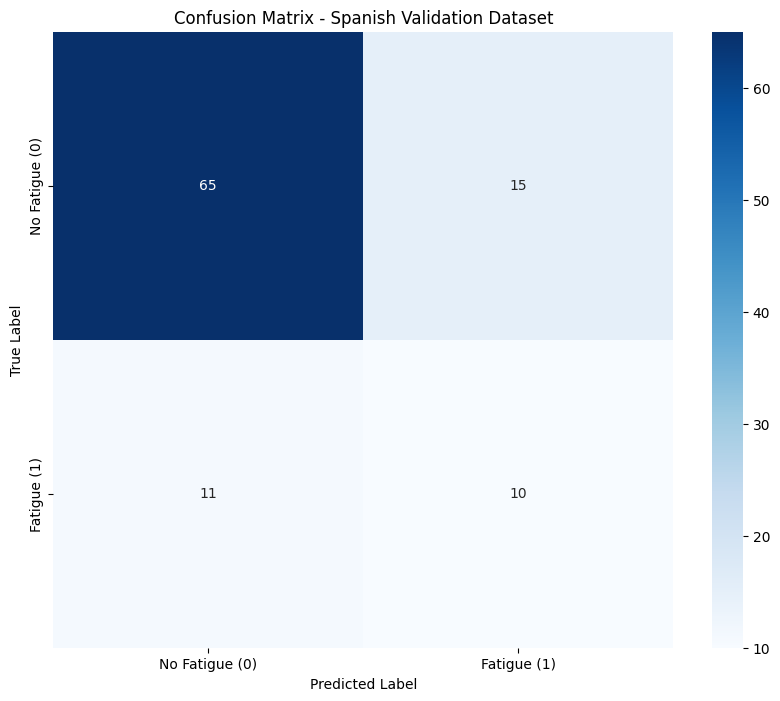


Detailed Confusion Matrix Interpretation:
True Negatives (Correctly predicted no fatigue): 65
False Positives (Incorrectly predicted fatigue): 15
False Negatives (Incorrectly predicted no fatigue): 11
True Positives (Correctly predicted fatigue): 10

Key Metrics:
Specificity (True Negative Rate): 0.812
Sensitivity (True Positive Rate): 0.476
Positive Predictive Value: 0.400
Negative Predictive Value: 0.855


In [29]:
# Create and plot confusion matrix with labels
cm = confusion_matrix(y_spain, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fatigue (0)', 'Fatigue (1)'],
            yticklabels=['No Fatigue (0)', 'Fatigue (1)'])
plt.title('Confusion Matrix - Spanish Validation Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and display detailed metrics
tn, fp, fn, tp = cm.ravel()
print("\nDetailed Confusion Matrix Interpretation:")
print(f"True Negatives (Correctly predicted no fatigue): {tn}")
print(f"False Positives (Incorrectly predicted fatigue): {fp}")
print(f"False Negatives (Incorrectly predicted no fatigue): {fn}")
print(f"True Positives (Correctly predicted fatigue): {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nKey Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")
print(f"Positive Predictive Value: {ppv:.3f}")
print(f"Negative Predictive Value: {npv:.3f}")

## Initial Remarks

16/04/2025
Our fatigue model trained in Scotland is over-calling fatigue in the Spanish dataset. AUC is 0.71 on validation which is reasonable, similar accuracy to calprotectin in some sense. 

Possible reasons why the model does not generalise as well:
- The weather and geography in Spain is nicer!
- Possible under-reporting of fatigue when asked by clinician vs written questionnaire?
- Cultural differences in how fatigue is perceived and reported?

Next steps:
- Cohort characteristics analysis and comparison with Scottish cohorts


## Interrogate Confusion Matrix

In [30]:
# Create masks for each category based on actual and predicted values
# Need to flatten y_pred since it might have an extra dimension
y_pred_flat = y_pred.flatten()
true_positive_mask = (y_spain == 1) & (y_pred_flat == 1)
true_negative_mask = (y_spain == 0) & (y_pred_flat == 0)
false_positive_mask = (y_spain == 0) & (y_pred_flat == 1)
false_negative_mask = (y_spain == 1) & (y_pred_flat == 0)

# Create separate dataframes
tp_df = X_spain[true_positive_mask].copy()
tn_df = X_spain[true_negative_mask].copy()
fp_df = X_spain[false_positive_mask].copy()
fn_df = X_spain[false_negative_mask].copy()

# Verify the numbers match the confusion matrix
print("Dataset sizes:")
print(f"True Positives: {len(tp_df)}")
print(f"True Negatives: {len(tn_df)}")
print(f"False Positives: {len(fp_df)}")
print(f"False Negatives: {len(fn_df)}")

Dataset sizes:
True Positives: 10
True Negatives: 65
False Positives: 15
False Negatives: 11


In [31]:
with open("output/dnn/export/shap_explainer_2025-04-09.pkl", "rb") as f:
    explainer = pickle.load(f)


In [32]:
shap_values = explainer.shap_values(fn_df)
shap_values_class_1 = shap_values[:, :, 0]
fn_df[numerical_features] = scaler.inverse_transform(
    fn_df[numerical_features]
)

100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


In [33]:
shap_values_class_1.shape

(11, 65)

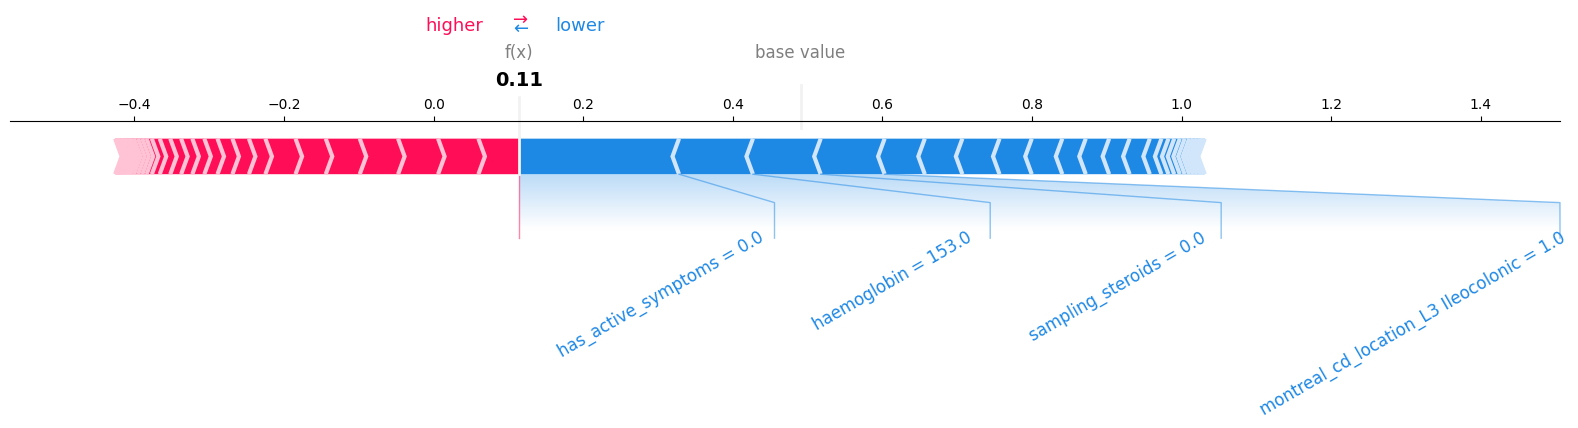

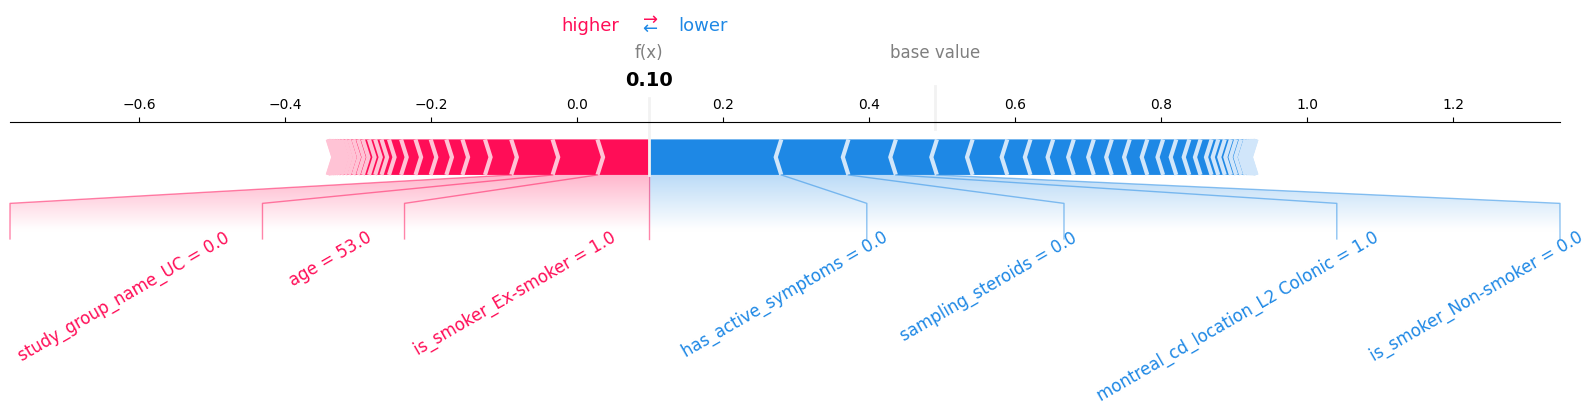

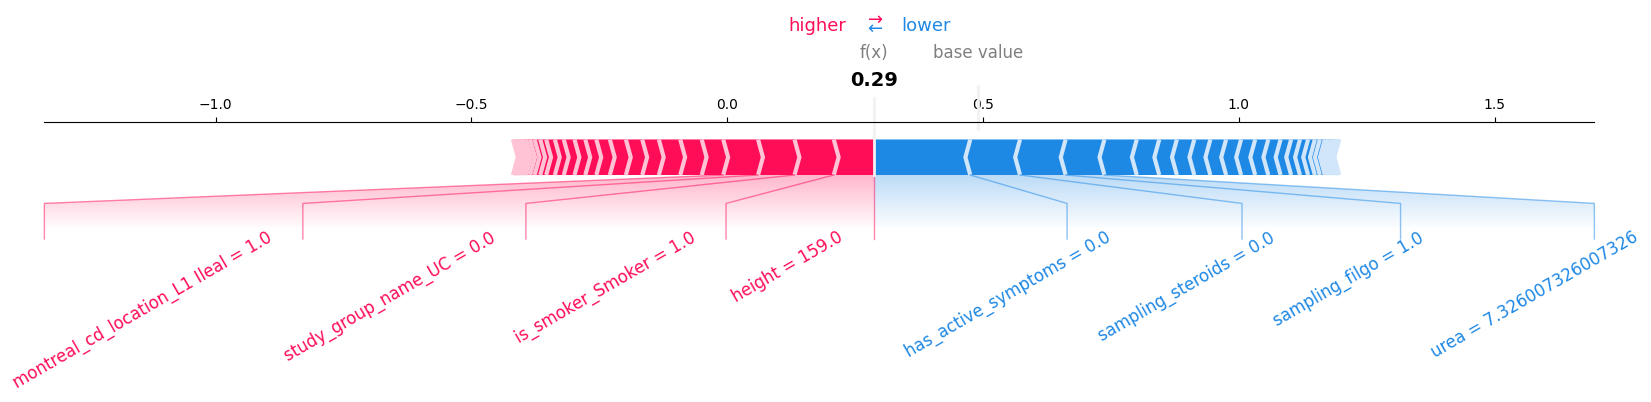

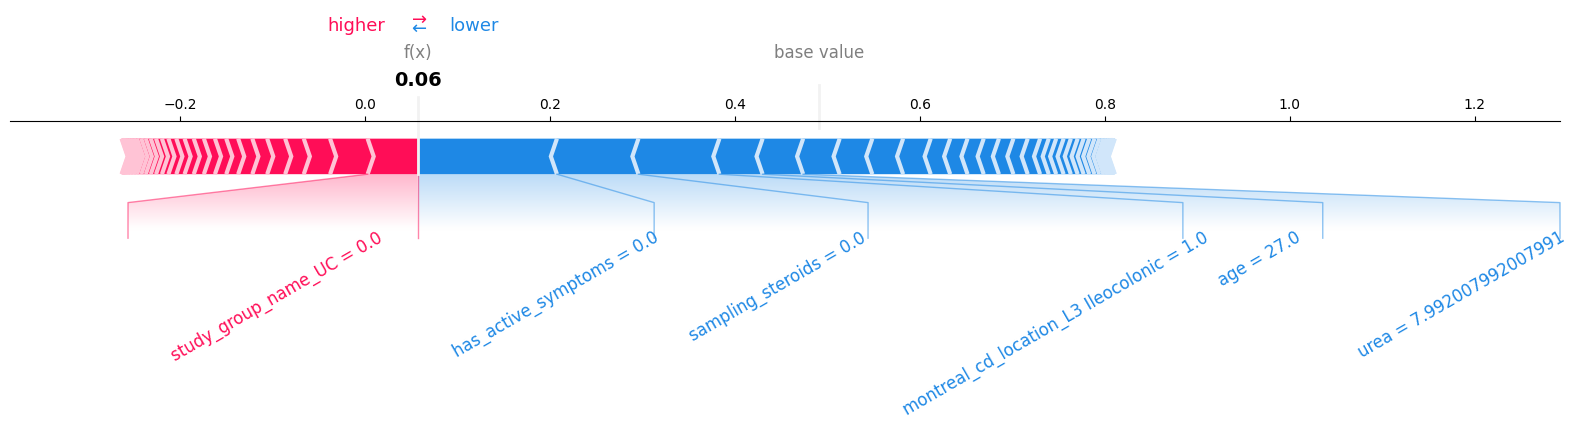

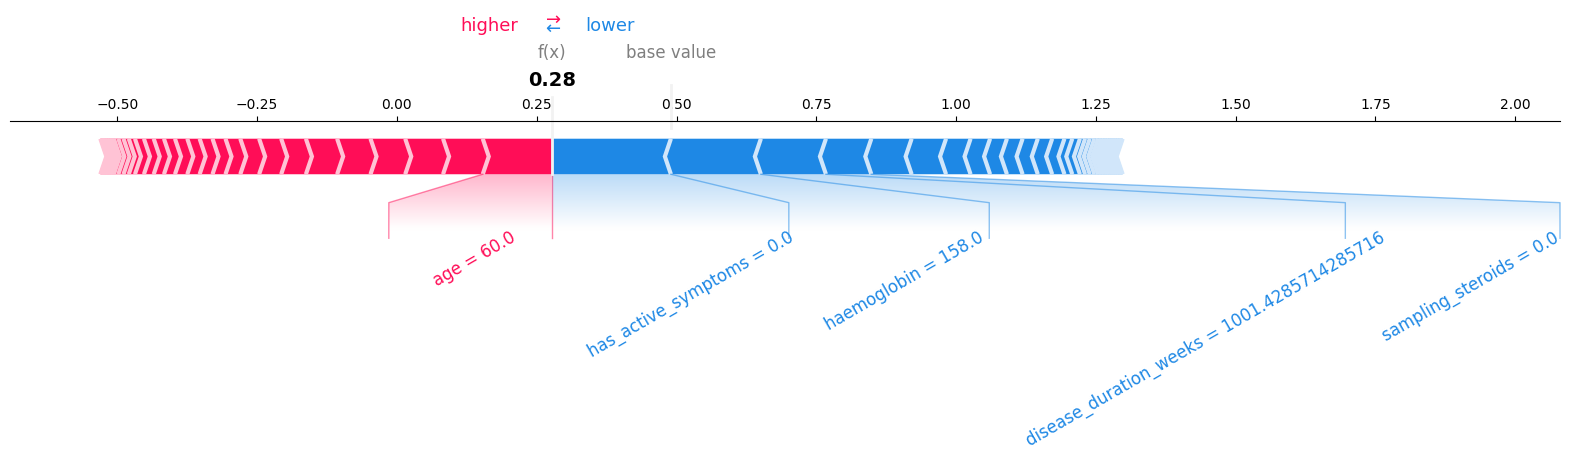

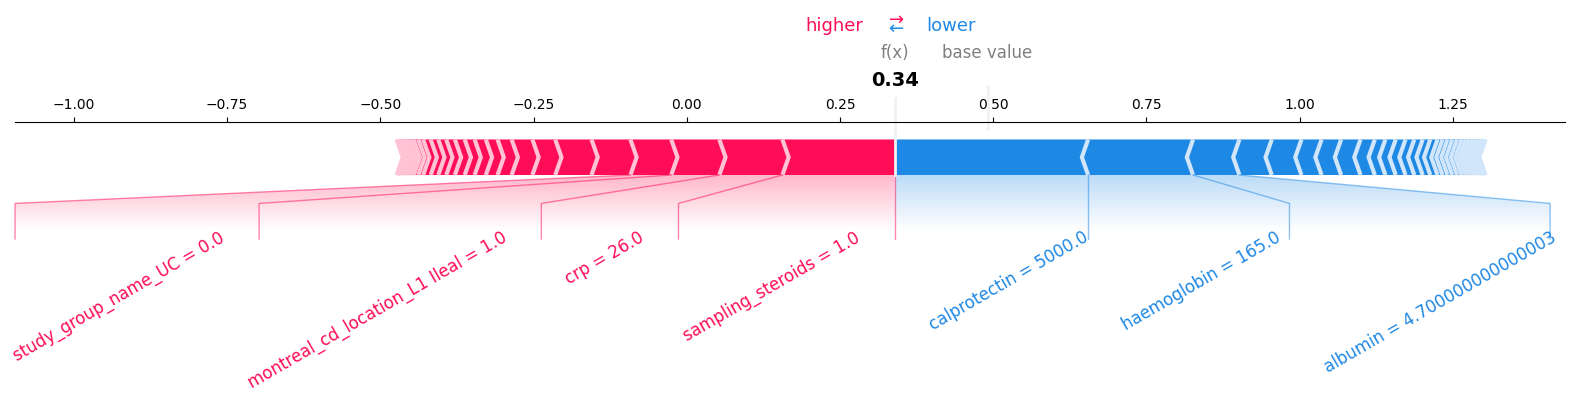

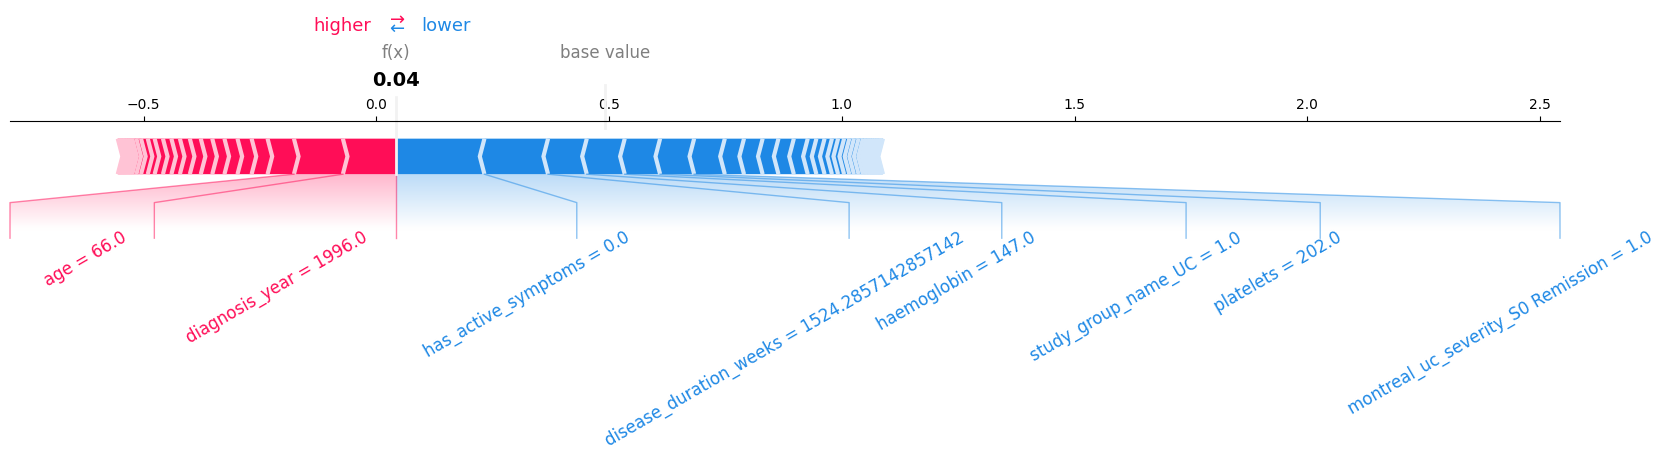

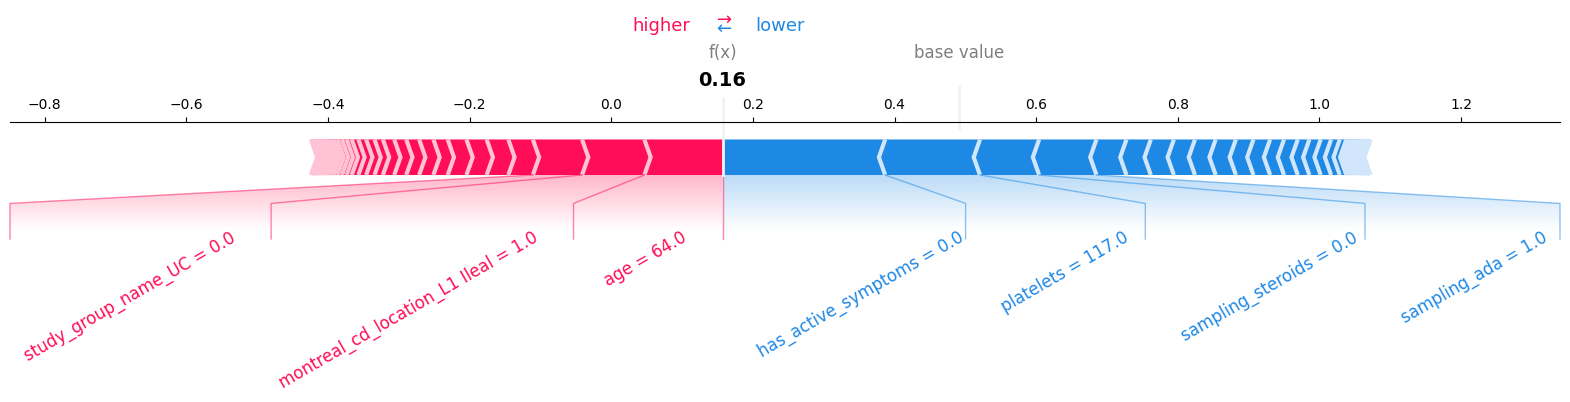

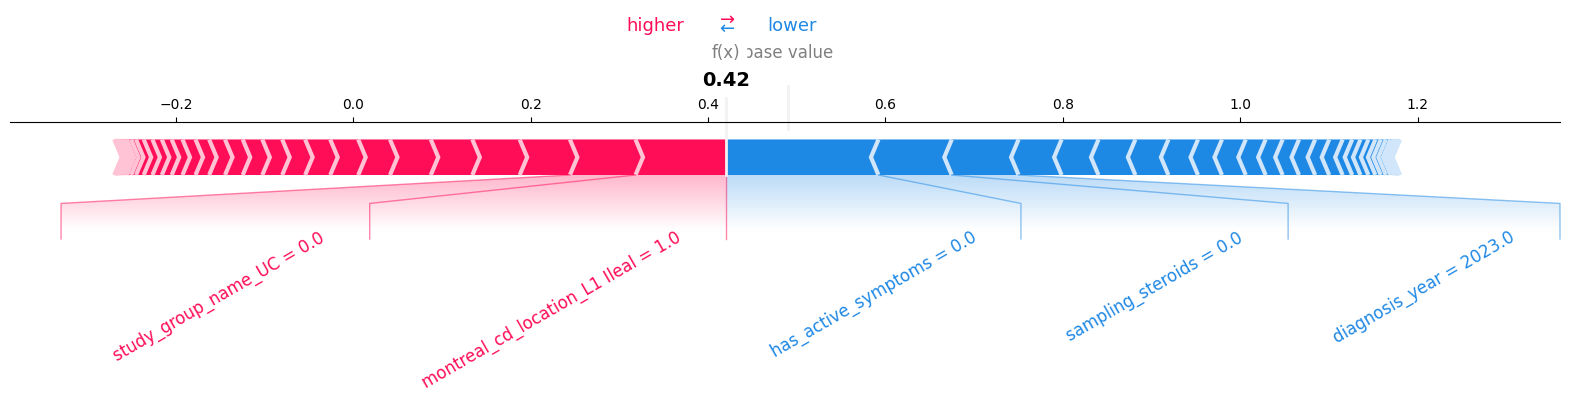

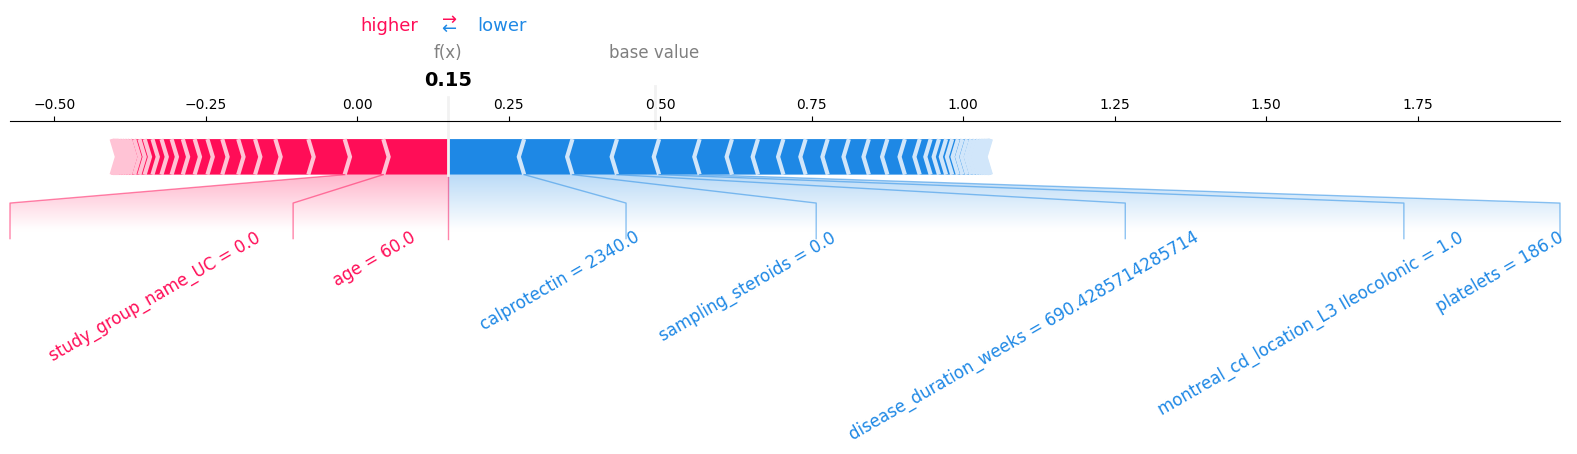

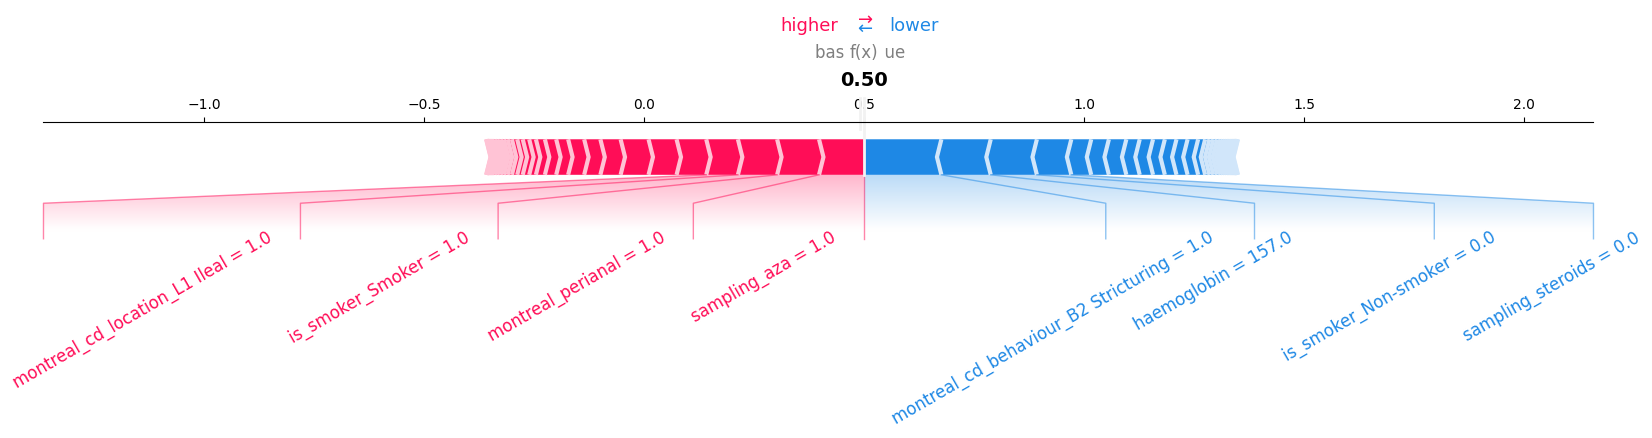

In [34]:
for i in range(len(fn_df)):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_class_1[i],
        fn_df.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
        plot_cmap="PRGn",
    )
    plt.show()

## Compare ML model vs Log Reg Model on this Cohort

In [35]:
# Modify the cell with ID 7470f457

# Add this as a new cell after the ROC plot cell

if not logreg_loaded:
    print("Logistic regression model was not loaded. Cannot compare misclassifications.")
else:
    # --- Get Binary Predictions ---
    # Keras DNN predictions (already calculated as y_pred)
    y_pred_dnn = y_pred.flatten() # Ensure it's a 1D array

    # Logistic Regression predictions
    y_pred_logreg = (y_pred_proba_logreg >= 0.5).astype(int)

    # --- Identify Classifications for Each Model ---
    # Using the index of the X_spain DataFrame to identify participants
    participant_indices = X_spain.index

    # Keras DNN
    tp_dnn_indices = participant_indices[(y_spain == 1) & (y_pred_dnn == 1)]
    tn_dnn_indices = participant_indices[(y_spain == 0) & (y_pred_dnn == 0)]
    fp_dnn_indices = participant_indices[(y_spain == 0) & (y_pred_dnn == 1)]
    fn_dnn_indices = participant_indices[(y_spain == 1) & (y_pred_dnn == 0)]

    # Logistic Regression
    tp_logreg_indices = participant_indices[(y_spain == 1) & (y_pred_logreg == 1)]
    tn_logreg_indices = participant_indices[(y_spain == 0) & (y_pred_logreg == 0)]
    fp_logreg_indices = participant_indices[(y_spain == 0) & (y_pred_logreg == 1)]
    fn_logreg_indices = participant_indices[(y_spain == 1) & (y_pred_logreg == 0)]

    # --- Compare True Positives ---
    tp_both = tp_dnn_indices.intersection(tp_logreg_indices)
    tp_dnn_only = tp_dnn_indices.difference(tp_logreg_indices)
    tp_logreg_only = tp_logreg_indices.difference(tp_dnn_indices)

    print("\n--- True Positive Comparison ---")
    print(f"Total TP (DNN): {len(tp_dnn_indices)}")
    print(f"Total TP (LogReg): {len(tp_logreg_indices)}")
    print(f"TP identified by BOTH models: {len(tp_both)}")
    print(f"TP identified by DNN ONLY: {len(tp_dnn_only)}")
    print(f"TP identified by LogReg ONLY: {len(tp_logreg_only)}")

    # --- Compare True Negatives ---
    tn_both = tn_dnn_indices.intersection(tn_logreg_indices)
    tn_dnn_only = tn_dnn_indices.difference(tn_logreg_indices)
    tn_logreg_only = tn_logreg_indices.difference(tn_dnn_indices)

    print("\n--- True Negative Comparison ---")
    print(f"Total TN (DNN): {len(tn_dnn_indices)}")
    print(f"Total TN (LogReg): {len(tn_logreg_indices)}")
    print(f"TN identified by BOTH models: {len(tn_both)}")
    print(f"TN identified by DNN ONLY: {len(tn_dnn_only)}")
    print(f"TN identified by LogReg ONLY: {len(tn_logreg_only)}")

    # --- Compare False Positives ---
    fp_both = fp_dnn_indices.intersection(fp_logreg_indices)
    fp_dnn_only = fp_dnn_indices.difference(fp_logreg_indices)
    fp_logreg_only = fp_logreg_indices.difference(fp_dnn_indices)

    print("\n--- False Positive Comparison ---")
    print(f"Total FP (DNN): {len(fp_dnn_indices)}")
    print(f"Total FP (LogReg): {len(fp_logreg_indices)}")
    print(f"FP identified by BOTH models: {len(fp_both)}")
    print(f"FP identified by DNN ONLY: {len(fp_dnn_only)}")
    print(f"FP identified by LogReg ONLY: {len(fp_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FP Both Indices: {fp_both.tolist()}")
    # print(f"FP DNN Only Indices: {fp_dnn_only.tolist()}")
    # print(f"FP LogReg Only Indices: {fp_logreg_only.tolist()}")


    # --- Compare False Negatives ---
    fn_both = fn_dnn_indices.intersection(fn_logreg_indices)
    fn_dnn_only = fn_dnn_indices.difference(fn_logreg_indices)
    fn_logreg_only = fn_logreg_indices.difference(fn_dnn_indices)

    print("\n--- False Negative Comparison ---")
    print(f"Total FN (DNN): {len(fn_dnn_indices)}")
    print(f"Total FN (LogReg): {len(fn_logreg_indices)}")
    print(f"FN identified by BOTH models: {len(fn_both)}")
    print(f"FN identified by DNN ONLY: {len(fn_dnn_only)}")
    print(f"FN identified by LogReg ONLY: {len(fn_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FN Both Indices: {fn_both.tolist()}")
    # print(f"FN DNN Only Indices: {fn_dnn_only.tolist()}")
    # print(f"FN LogReg Only Indices: {fn_logreg_only.tolist()}")



--- True Positive Comparison ---
Total TP (DNN): 10
Total TP (LogReg): 8
TP identified by BOTH models: 8
TP identified by DNN ONLY: 2
TP identified by LogReg ONLY: 0

--- True Negative Comparison ---
Total TN (DNN): 65
Total TN (LogReg): 67
TN identified by BOTH models: 61
TN identified by DNN ONLY: 4
TN identified by LogReg ONLY: 6

--- False Positive Comparison ---
Total FP (DNN): 15
Total FP (LogReg): 13
FP identified by BOTH models: 9
FP identified by DNN ONLY: 6
FP identified by LogReg ONLY: 4

--- False Negative Comparison ---
Total FN (DNN): 11
Total FN (LogReg): 13
FN identified by BOTH models: 11
FN identified by DNN ONLY: 0
FN identified by LogReg ONLY: 2


In [41]:
import shap # Make sure shap is imported
import pandas as pd
import numpy as np

# --- Check if models and explainer are loaded ---
if 'explainer' not in locals():
    print("SHAP explainer not found. Please load it first (e.g., from 'output/dnn/export/shap_explainer_2025-04-09.pkl').")
elif not logreg_loaded:
    print("Logistic regression model was not loaded. Cannot compare feature importance.")
else:
    print("\\n--- Calculating Feature Importance ---")

    # --- DNN Feature Importance (Mean Absolute SHAP) ---
    # Calculate SHAP values for the entire Spanish validation set
    # Assuming explainer.shap_values returns a list [shap_values_class_0, shap_values_class_1]
    # Or if it returns a single array, it's likely for the positive class already.
    # Adjust index [1] if your explainer structure is different.
    try:
        if 'shap_values_spain' not in locals() and 'shap_values_spain' not in globals():
            print("Calculating SHAP values for DNN (this may take a while)...")
            shap_values_spain = explainer.shap_values(X_spain)
            print("SHAP values calculated.")
        else:
            print("Using previously calculated SHAP values for DNN.")

        shap_values_positive_class = shap_values_spain[:, :, 0]

        # Calculate mean absolute SHAP values
        mean_abs_shap = np.mean(np.abs(shap_values_positive_class), axis=0)
        dnn_importance = pd.Series(mean_abs_shap, index=X_spain.columns, name='DNN_MeanAbsSHAP')
        dnn_importance_sorted = dnn_importance.sort_values(ascending=False)
        print("\\nTop 10 DNN Features (Mean Absolute SHAP):")
        print(dnn_importance_sorted.head(10))
        dnn_calculated = True

    except Exception as e:
        print(f"Error calculating SHAP values for DNN: {e}")
        dnn_calculated = False


    # --- Logistic Regression Feature Importance (Coefficient Magnitude & p-value) ---
    logreg_params = logreg_model.params.drop('const', errors='ignore') # Drop intercept
    logreg_pvalues = logreg_model.pvalues.drop('const', errors='ignore')
    logreg_abs_coeffs = logreg_params.abs()

    logreg_importance = pd.DataFrame({
        'LogReg_AbsCoeff': logreg_abs_coeffs,
        'LogReg_PValue': logreg_pvalues
    })
    # Sort by absolute coefficient magnitude first, then p-value
    logreg_importance_sorted = logreg_importance.sort_values(by=['LogReg_AbsCoeff', 'LogReg_PValue'], ascending=[False, True])
    print("\\nTop 10 LogReg Features (Absolute Coefficient & P-value):")
    print(logreg_importance_sorted.head(10))
    logreg_calculated = True


    # --- Combined Comparison Table ---
    if dnn_calculated and logreg_calculated:
        comparison_df = pd.concat([dnn_importance, logreg_importance], axis=1).fillna(0) # Fill NaNs if featuresets differ slightly

        # Add ranks
        comparison_df['DNN_Rank'] = comparison_df['DNN_MeanAbsSHAP'].rank(ascending=False, method='first')
        comparison_df['LogReg_Rank'] = comparison_df['LogReg_AbsCoeff'].rank(ascending=False, method='first')

        # Sort by average rank or one model's rank
        comparison_df_sorted = comparison_df.sort_values(by='DNN_Rank')

        print("\\n--- Feature Importance Comparison (DNN vs LogReg) ---")
        # Display relevant columns
        print(comparison_df_sorted[['DNN_MeanAbsSHAP', 'DNN_Rank', 'LogReg_AbsCoeff', 'LogReg_PValue', 'LogReg_Rank']].head(20)) # Show top 20 by DNN rank


\n--- Calculating Feature Importance ---
Using previously calculated SHAP values for DNN.
\nTop 10 DNN Features (Mean Absolute SHAP):
has_active_symptoms                    0.132916
sampling_steroids                      0.086389
study_group_name_UC                    0.067585
age                                    0.058873
disease_duration_weeks                 0.053154
montreal_cd_location_L3 Ileocolonic    0.042687
diagnosis_year                         0.042415
calprotectin                           0.041739
haemoglobin                            0.040986
platelets                              0.036984
Name: DNN_MeanAbsSHAP, dtype: float64
\nTop 10 LogReg Features (Absolute Coefficient & P-value):
                       LogReg_AbsCoeff  LogReg_PValue
sampling_risa                18.972627       0.999428
season_autumn                18.212733       0.990834
season_spring                17.956538       0.990963
season_winter                17.865267       0.991009
season_summer      

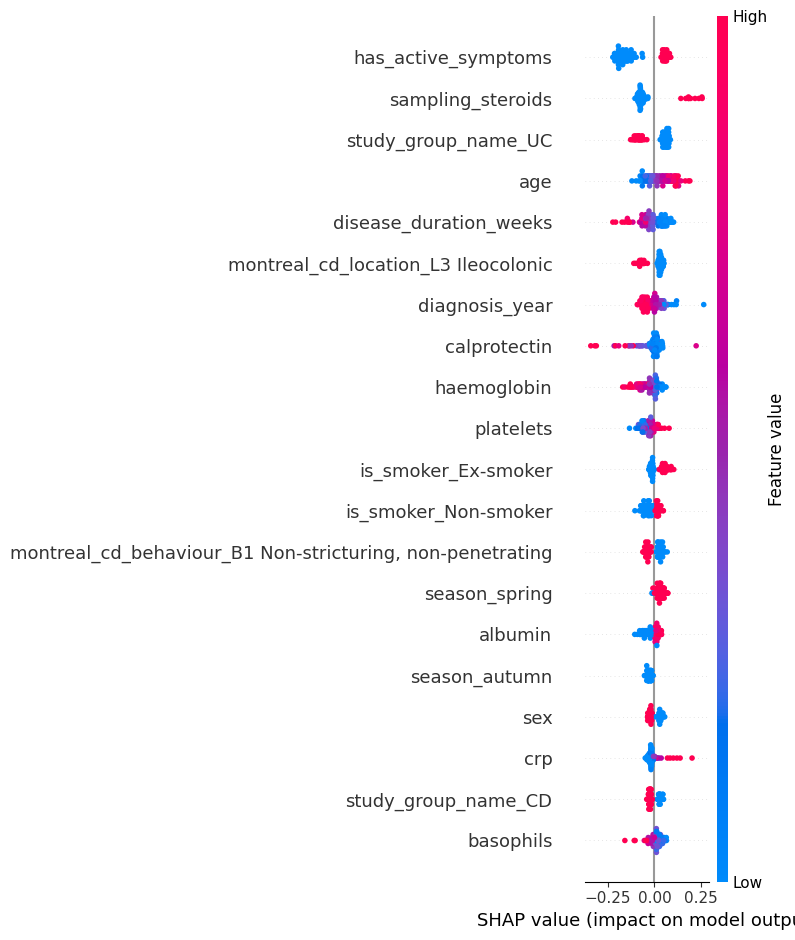

In [50]:


shap.summary_plot(
    shap_values_positive_class,
    X_spain,
    feature_names=X_spain.columns,
    show=False,
    max_display=20,
)
plt.tight_layout()
plt.show()